In [2]:
import yfinance as yf
import datetime

import pandas as pd
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
base_currency = 'HKD'
FX_list = [
    # Major currencies
    'USD', 'GBP', 'CHF', 'JPY', 'CNY', 'EUR',
    'CAD', 'AUD', 'NZD', 
    
    # Nordic currencies
    'NOK', 'SEK', 'DKK', 'ISK',
    
    # Asian currencies
    'SGD', 'TWD', 'KRW', 'IDR', 'MYR', 'THB', 'PHP', 'INR',
    
    # Emerging market currencies
    'TRY', 'ZAR', 'MXN', 'BRL', 'ARS', 'CLP', 'COP', 'PEN',
    
    # Eastern European currencies
    'PLN', 'HUF', 'CZK', 'RUB', 'RON', 'BGN', 'HRK',
    
    # Middle Eastern currencies
    'ILS', 'SAR', 'AED', 'QAR', 'KWD', 'BHD',
    
    # Other significant currencies
    'HKD', 'VND', 'EGP', 'PKR', 'JMD', 'NGN', 'GHS', 'KES'
]

# Remove the base currency from the list if it's in there
while base_currency in FX_list:
    FX_list.remove(base_currency)

tickers = [f"{base_currency}{quote}=X" for quote in FX_list]

In [51]:
def get_fx_data(base_currency, fx_list, period='2y', interval='1d', missing_threshold=0.3):
    if base_currency in fx_list:
        fx_list.remove(base_currency)
    
    tickers = [f"{base_currency}{quote}=X" for quote in fx_list]
    ticker_to_currency = {f"{base_currency}{quote}=X": quote for quote in fx_list}

    data = yf.download(tickers, period=period, interval=interval)
    
    if len(tickers) > 1:
        price = data['Close']
        price.columns = [ticker_to_currency[ticker] for ticker in price.columns]
    else:
        price = pd.DataFrame(data['Close'])
        price.columns = [ticker_to_currency[tickers[0]]]
    
    print(f"Shape of price data: {price.shape}")
    print(f"Missing values: {price.isnull().sum().sum()}")
    
    missing_percent = price.isnull().mean()
    columns_to_drop = missing_percent[missing_percent > missing_threshold].index
    price = price.drop(columns=columns_to_drop)
    if len(columns_to_drop) > 0:
        print(f"Dropped currencies with >{missing_threshold*100}% missing data: {list(columns_to_drop)}")
    
    price = price.ffill()
    
    print(f"Final shape of price data: {price.shape}")
    print(f"Currencies included: {list(price.columns)}")
    
    return price

In [53]:
#price = get_fx_data(base_currency, FX_list, period='60d', interval='5m')
price = get_fx_data(base_currency, FX_list)

[*********************100%***********************]  49 of 49 completed

21 Failed downloads:
['HKDCOP=X', 'HKDGHS=X', 'HKDSAR=X', 'HKDHRK=X', 'HKDISK=X', 'HKDQAR=X', 'HKDKWD=X', 'HKDCZK=X', 'HKDCLP=X', 'HKDARS=X', 'HKDBHD=X', 'HKDPEN=X', 'HKDRON=X', 'HKDNGN=X', 'HKDEGP=X', 'HKDKES=X', 'HKDRUB=X', 'HKDTRY=X', 'HKDJMD=X', 'HKDBGN=X', 'HKDHUF=X']: YFPricesMissingError('possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")')


Shape of price data: (520, 49)
Missing values: 13515
Dropped currencies with >30.0% missing data: ['AED', 'ARS', 'BGN', 'BHD', 'CLP', 'COP', 'CZK', 'EGP', 'GHS', 'HRK', 'HUF', 'ILS', 'ISK', 'JMD', 'KES', 'KWD', 'NGN', 'NOK', 'PEN', 'PHP', 'QAR', 'RON', 'RUB', 'SAR', 'TRY', 'VND']
Final shape of price data: (520, 23)
Currencies included: ['AUD', 'BRL', 'CAD', 'CHF', 'CNY', 'DKK', 'EUR', 'GBP', 'IDR', 'INR', 'JPY', 'KRW', 'MXN', 'MYR', 'NZD', 'PKR', 'PLN', 'SEK', 'SGD', 'THB', 'TWD', 'USD', 'ZAR']


Can we find correlated pair?

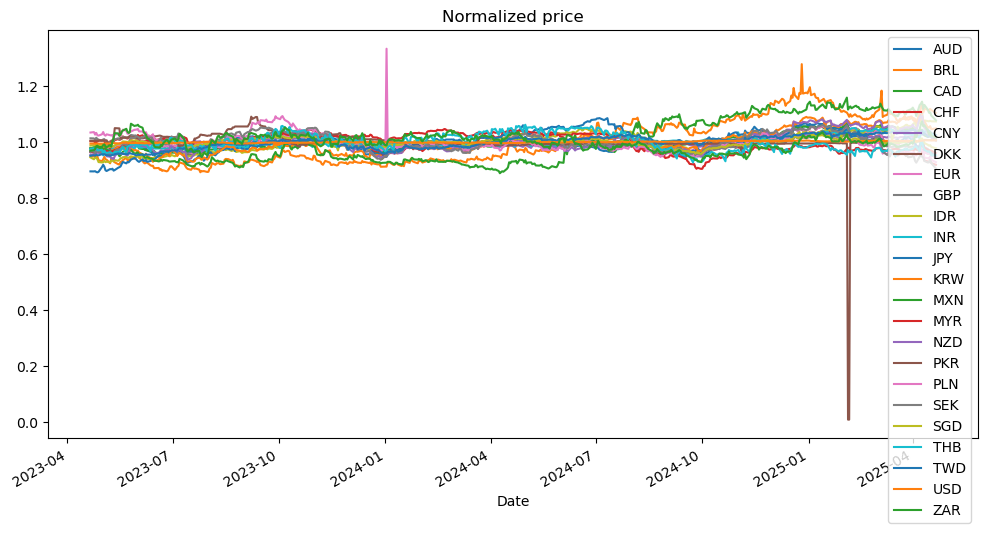

In [55]:
plt.figure(figsize=(12,6))
for D in price.columns:
    (price[D]/price[D].mean()).plot()
plt.title('Normalized price')
plt.legend()
plt.show()

# Just try some good old StaArb

In [59]:
def build_pairs_trading_backtest(price_data, train_test_split=0.7, correlation_threshold=0.8, 
                                lookback_period=30, z_entry=2.0, z_exit=0.0, 
                                initial_capital=10000.0, stop_loss=0.9, transaction_fee=0.01,
                                leverage=10):
    split_idx = int(len(price_data) * train_test_split)
    train_data = price_data.iloc[:split_idx].copy()
    test_data = price_data.iloc[split_idx:].copy()
    
    print(f"Training data: {train_data.index[0]} to {train_data.index[-1]} ({len(train_data)} rows)")
    print(f"Testing data: {test_data.index[0]} to {test_data.index[-1]} ({len(test_data)} rows)")
    
    corr_matrix = train_data.corr()
    
    pairs = list(itertools.combinations(price_data.columns, 2))
    
    backtest_results = []
    
    for pair1, pair2 in pairs:
        correlation = corr_matrix.loc[pair1, pair2]
        
        if abs(correlation) > correlation_threshold:
            try:
                pair_train = train_data[[pair1, pair2]].dropna()
                pair_test = test_data[[pair1, pair2]].dropna()
                
                if len(pair_train) < lookback_period * 2 or len(pair_test) < lookback_period * 2:
                    continue
                
                X_train = pair_train[pair1].values.reshape(-1, 1)
                y_train = pair_train[pair2].values
                model = LinearRegression().fit(X_train, y_train)
                hedge_ratio = model.coef_[0]
                
                spread = pair_test[pair2] - hedge_ratio * pair_test[pair1]
                
                rolling_mean = spread.rolling(window=lookback_period).mean()
                rolling_std = spread.rolling(window=lookback_period).std()
                z_scores = (spread - rolling_mean) / rolling_std
                
                signals = pd.DataFrame(index=pair_test.index)
                signals['z_score'] = z_scores
                signals['pair1'] = pair_test[pair1]
                signals['pair2'] = pair_test[pair2]
                signals['position_pair1'] = 0.0
                signals['position_pair2'] = 0.0
                
                in_position = False
                entry_z = 0
                entry_date = None
                trade_history = []
                
                valid_indices = z_scores.dropna().index
                if len(valid_indices) < 5:
                    continue
                    
                start_idx = valid_indices[0]
                start_pos = signals.index.get_loc(start_idx)
                
                # Track equity (actual cash) and portfolio value
                equity = initial_capital  # This is the actual capital we own
                portfolio_value = initial_capital
                initial_pair_capital = initial_capital
                daily_portfolio_values = []
                
                # Keep track if trading is disabled for this pair
                pair_disabled = False
                
                for i in range(start_pos, len(signals)):
                    curr_date = signals.index[i]
                    curr_z = signals['z_score'].iloc[i]
                    
                    if np.isnan(curr_z):
                        daily_portfolio_values.append({
                            'date': curr_date,
                            'portfolio_value': portfolio_value
                        })
                        continue
                    
                    if pair_disabled:
                        daily_portfolio_values.append({
                            'date': curr_date,
                            'portfolio_value': portfolio_value
                        })
                        continue
                    
                    # Check if we're completely wiped out
                    if portfolio_value <= 0 and not in_position:
                        pair_disabled = True
                        portfolio_value = 0
                        print(f"Trading disabled for pair {pair1}-{pair2} as portfolio value dropped to zero (complete loss of initial capital)")
                        daily_portfolio_values.append({
                            'date': curr_date,
                            'portfolio_value': portfolio_value
                        })
                        continue
                    
                    if not in_position and portfolio_value > 0:
                        if abs(curr_z) > z_entry:
                            in_position = True
                            entry_z = curr_z
                            entry_date = curr_date
                            
                            entry_price1 = signals.loc[entry_date, 'pair1']
                            entry_price2 = signals.loc[entry_date, 'pair2']
                            
                            # Calculate leveraged position size based on current equity
                            equity_used = portfolio_value  # Using all available equity
                            leveraged_capital = equity_used * leverage  # Total buying power with leverage
                            
                            # Calculate transaction costs
                            entry_fee1 = equity_used * 0.5 * transaction_fee
                            entry_fee2 = equity_used * 0.5 * transaction_fee
                            total_entry_fees = entry_fee1 + entry_fee2
                            
                            # Deduct fees from equity
                            portfolio_value -= total_entry_fees
                            
                            # Record positions with proper hedge ratio
                            if curr_z > 0:
                                signals.loc[signals.index[i]:, 'position_pair1'] = 1.0
                                signals.loc[signals.index[i]:, 'position_pair2'] = -hedge_ratio
                            else:
                                signals.loc[signals.index[i]:, 'position_pair1'] = -1.0
                                signals.loc[signals.index[i]:, 'position_pair2'] = hedge_ratio
                    
                    elif in_position:
                        current_price1 = signals.loc[curr_date, 'pair1']
                        current_price2 = signals.loc[curr_date, 'pair2']
                        
                        position1 = signals.loc[entry_date, 'position_pair1']
                        position2 = signals.loc[entry_date, 'position_pair2']
                        
                        # Calculate percentage changes in prices
                        pct_change1 = (current_price1 - entry_price1) / entry_price1
                        pct_change2 = (current_price2 - entry_price2) / entry_price2
                        
                        # Calculate returns with leverage effect
                        # For a strategy that allocates 50% to each asset
                        leveraged_return1 = equity_used * 0.5 * position1 * pct_change1 * leverage
                        leveraged_return2 = equity_used * 0.5 * position2 * pct_change2 * leverage
                        
                        # Total dollar return from this trade so far
                        current_trade_return = leveraged_return1 + leveraged_return2
                        
                        # Current theoretical portfolio value 
                        current_portfolio_value = equity_used - total_entry_fees + current_trade_return
                        
                        # Check if we're at a total loss (100% of equity used)
                        stop_loss_triggered = current_portfolio_value <= 0
                        
                        if ((entry_z > 0 and curr_z <= z_exit) or 
                            (entry_z < 0 and curr_z >= z_exit) or
                            stop_loss_triggered):
                            
                            exit_date = curr_date
                            exit_price1 = current_price1
                            exit_price2 = current_price2
                            
                            # Calculate final percentage changes
                            pct_change1 = (exit_price1 - entry_price1) / entry_price1
                            pct_change2 = (exit_price2 - entry_price2) / entry_price2
                            
                            # Calculate final returns with leverage
                            leveraged_return1 = equity_used * 0.5 * position1 * pct_change1 * leverage
                            leveraged_return2 = equity_used * 0.5 * position2 * pct_change2 * leverage
                            
                            # Total dollar return from this trade
                            total_dollar_return = leveraged_return1 + leveraged_return2
                            
                            if stop_loss_triggered:
                                # In case of total loss, we cap the loss at the equity used
                                total_dollar_return = -equity_used
                                portfolio_value = 0
                                pair_disabled = True
                                
                                # No exit fees when totally wiped out
                                total_exit_fees = 0
                                exit_reason = "total_loss"
                            else:
                                # Normal exit - calculate exit fees
                                # Calculate the position values after P&L
                                position_value1 = equity_used * 0.5 * (1 + position1 * pct_change1 * leverage)
                                position_value2 = equity_used * 0.5 * (1 + position2 * pct_change2 * leverage)
                                
                                # Fees on the actual currency amount
                                exit_fee1 = position_value1 * transaction_fee if position_value1 > 0 else 0
                                exit_fee2 = position_value2 * transaction_fee if position_value2 > 0 else 0
                                total_exit_fees = exit_fee1 + exit_fee2
                                
                                # Adjust dollar return by exit fees
                                total_dollar_return -= total_exit_fees
                                
                                # Update portfolio value with actual return
                                portfolio_value += total_dollar_return
                                portfolio_value = max(portfolio_value, 0)  # Can't go below zero
                                
                                if ((entry_z > 0 and curr_z <= z_exit) or 
                                    (entry_z < 0 and curr_z >= z_exit)):
                                    exit_reason = "signal"
                                else:
                                    exit_reason = "stop_loss"
                            
                            # Calculate return percentage relative to equity used
                            total_pct_return = total_dollar_return / equity_used * 100 if equity_used > 0 else -100
                            
                            # Record trade details
                            trade_history.append({
                                'entry_date': entry_date,
                                'exit_date': exit_date,
                                'entry_z': entry_z,
                                'exit_z': curr_z,
                                'position1': position1,
                                'position2': position2,
                                'entry_price1': entry_price1,
                                'entry_price2': entry_price2,
                                'exit_price1': exit_price1,
                                'exit_price2': exit_price2,
                                'pct_change1': pct_change1,
                                'pct_change2': pct_change2,
                                'leveraged_return1': leveraged_return1,
                                'leveraged_return2': leveraged_return2,
                                'total_dollar_return': total_dollar_return,
                                'total_pct_return': total_pct_return,
                                'portfolio_value': portfolio_value,
                                'duration': (exit_date - entry_date).days,
                                'entry_fees': total_entry_fees,
                                'exit_fees': total_exit_fees,
                                'total_fees': total_entry_fees + total_exit_fees,
                                'leverage': leverage,
                                'equity_used': equity_used,
                                'exit_reason': exit_reason
                            })
                            
                            # Reset position
                            in_position = False
                            signals.loc[signals.index[i]:, 'position_pair1'] = 0.0
                            signals.loc[signals.index[i]:, 'position_pair2'] = 0.0
                    
                    # Record the daily portfolio value
                    daily_portfolio_values.append({
                        'date': curr_date,
                        'portfolio_value': portfolio_value
                    })
                
                # Create a dataframe of daily portfolio values
                portfolio_df = pd.DataFrame(daily_portfolio_values)
                if len(portfolio_df) > 0:
                    portfolio_df.set_index('date', inplace=True)
                    signals['portfolio_value'] = portfolio_df['portfolio_value']
                
                    signals['daily_returns'] = signals['portfolio_value'].pct_change()
                
                total_trades = len(trade_history)
                
                if total_trades > 0:
                    winning_trades = sum(1 for trade in trade_history if trade['total_dollar_return'] > 0)
                    losing_trades = total_trades - winning_trades
                    
                    win_rate = winning_trades / total_trades
                    
                    avg_return = np.mean([trade['total_pct_return'] for trade in trade_history])
                    avg_win = np.mean([trade['total_pct_return'] for trade in trade_history if trade['total_pct_return'] > 0]) if winning_trades > 0 else 0
                    avg_loss = np.mean([trade['total_pct_return'] for trade in trade_history if trade['total_pct_return'] <= 0]) if losing_trades > 0 else 0
                    
                    sum_wins = sum(trade['total_dollar_return'] for trade in trade_history if trade['total_dollar_return'] > 0)
                    sum_losses = abs(sum(trade['total_dollar_return'] for trade in trade_history if trade['total_dollar_return'] < 0))
                    profit_factor = sum_wins / sum_losses if sum_losses > 0 else float('inf')
                    
                    total_fees = sum(trade['total_fees'] for trade in trade_history)
                    
                    total_loss_trades = sum(1 for trade in trade_history if trade['exit_reason'] == 'total_loss')
                    stop_loss_trades = sum(1 for trade in trade_history if trade['exit_reason'] == 'stop_loss')
                    signal_trades = sum(1 for trade in trade_history if trade['exit_reason'] == 'signal')
                    
                    portfolio_values = signals['portfolio_value'].dropna()
                    
                    if len(portfolio_values) > 0:
                        running_max = portfolio_values.cummax()
                        drawdown = (portfolio_values / running_max - 1) * 100
                        max_drawdown = drawdown.min()
                    else:
                        max_drawdown = 0
                    
                    start_date = signals.index[0]
                    end_date = signals.index[-1]
                    start_value = initial_capital
                    end_value = portfolio_value
                    
                    days = (end_date - start_date).days
                    years = days / 365 if days > 0 else 1
                    
                    annual_return = ((end_value / start_value) ** (1 / years) - 1) * 100
                    
                    daily_returns = signals['daily_returns'].dropna()
                    
                    if len(daily_returns) > 1:
                        annual_volatility = daily_returns.std() * np.sqrt(252) * 100
                        
                        daily_mean_return = daily_returns.mean()
                        annual_mean_return = ((1 + daily_mean_return) ** 252 - 1) * 100
                        
                        sharpe_ratio = annual_mean_return / annual_volatility if annual_volatility > 0 else 0
                    else:
                        annual_volatility = 0
                        sharpe_ratio = 0
                else:
                    winning_trades = 0
                    losing_trades = 0
                    win_rate = 0
                    avg_return = 0
                    avg_win = 0
                    avg_loss = 0
                    profit_factor = 0
                    annual_return = 0
                    annual_volatility = 0
                    sharpe_ratio = 0
                    max_drawdown = 0
                    total_fees = 0
                    total_loss_trades = 0
                    stop_loss_trades = 0
                    signal_trades = 0
                
                backtest_results.append({
                    'pair1': pair1,
                    'pair2': pair2,
                    'correlation': correlation,
                    'hedge_ratio': hedge_ratio,
                    'total_trades': total_trades,
                    'winning_trades': winning_trades,
                    'losing_trades': losing_trades,
                    'win_rate': win_rate,
                    'avg_return': avg_return,
                    'avg_win': avg_win,
                    'avg_loss': avg_loss,
                    'profit_factor': profit_factor,
                    'annual_return': annual_return,
                    'annual_volatility': annual_volatility,
                    'sharpe_ratio': sharpe_ratio,
                    'max_drawdown': max_drawdown,
                    'final_portfolio_value': portfolio_value,
                    'total_fees': total_fees,
                    'stop_loss_trades': stop_loss_trades,
                    'total_loss_trades': total_loss_trades,
                    'signal_trades': signal_trades,
                    'pair_disabled': pair_disabled,
                    'trade_history': trade_history,
                    'signals': signals
                })
                
            except Exception as e:
                print(f"Error processing pair {pair1} - {pair2}: {str(e)}")
                continue
    
    results_df = pd.DataFrame(backtest_results)
    
    if len(results_df) > 0:
        all_portfolios = {}
        for _, row in results_df.iterrows():
            signals = row['signals']
            if 'portfolio_value' in signals.columns:
                portfolio = signals['portfolio_value'].dropna()
                if len(portfolio) > 0:
                    pair_name = f"{row['pair1']}_{row['pair2']}"
                    all_portfolios[pair_name] = portfolio
        
        common_dates = set()
        for portfolio in all_portfolios.values():
            if len(common_dates) == 0:
                common_dates = set(portfolio.index)
            else:
                common_dates = common_dates.intersection(set(portfolio.index))
        
        common_dates = sorted(common_dates)
        
        if common_dates:
            overall_portfolio = pd.DataFrame(index=common_dates)
            
            for pair_name, portfolio in all_portfolios.items():
                overall_portfolio[pair_name] = portfolio.loc[common_dates]
            
            n_strategies = len(all_portfolios)
            total_initial_capital = initial_capital * n_strategies
            
            overall_portfolio['total'] = overall_portfolio.sum(axis=1)
            
            overall_returns = overall_portfolio['total'].pct_change().dropna()
            
            if len(overall_returns) > 1:
                annual_mean_return = ((1 + overall_returns.mean()) ** 252 - 1) * 100
                annual_volatility = overall_returns.std() * np.sqrt(252) * 100
                overall_sharpe = annual_mean_return / annual_volatility if annual_volatility > 0 else 0
                
                running_max = overall_portfolio['total'].cummax()
                drawdown = (overall_portfolio['total'] / running_max - 1) * 100
                overall_max_drawdown = drawdown.min()
                
                start_value = total_initial_capital
                end_value = overall_portfolio['total'].iloc[-1]
                total_return = (end_value / start_value - 1) * 100
                
                days = (overall_portfolio.index[-1] - overall_portfolio.index[0]).days
                years = days / 365 if days > 0 else 1
                overall_annual_return = ((end_value / start_value) ** (1 / years) - 1) * 100
                
                total_fees = sum(row['total_fees'] for _, row in results_df.iterrows() if 'total_fees' in row)
                disabled_pairs = sum(1 for _, row in results_df.iterrows() if row['pair_disabled'])
                total_loss_pairs = sum(1 for _, row in results_df.iterrows() 
                                     if 'total_loss_trades' in row and row['total_loss_trades'] > 0)
                
                overall_metrics = {
                    'sharpe_ratio': overall_sharpe,
                    'max_drawdown': overall_max_drawdown,
                    'annual_return': overall_annual_return,
                    'total_return': total_return,
                    'final_value': end_value,
                    'start_value': start_value,
                    'total_fees': total_fees,
                    'disabled_pairs': disabled_pairs,
                    'total_loss_pairs': total_loss_pairs,
                    'portfolio_data': overall_portfolio
                }
            else:
                overall_metrics = {
                    'sharpe_ratio': 0,
                    'max_drawdown': 0,
                    'annual_return': 0,
                    'total_return': 0,
                    'final_value': total_initial_capital,
                    'start_value': total_initial_capital,
                    'total_fees': 0,
                    'disabled_pairs': 0,
                    'total_loss_pairs': 0,
                    'portfolio_data': overall_portfolio
                }
        else:
            overall_metrics = {
                'sharpe_ratio': 0,
                'max_drawdown': 0,
                'annual_return': 0,
                'total_return': 0,
                'final_value': initial_capital * len(results_df),
                'start_value': initial_capital * len(results_df),
                'total_fees': 0,
                'disabled_pairs': 0,
                'total_loss_pairs': 0,
                'portfolio_data': pd.DataFrame()
            }
    else:
        overall_metrics = {
            'sharpe_ratio': 0,
            'max_drawdown': 0,
            'annual_return': 0,
            'total_return': 0,
            'final_value': 0,
            'start_value': 0,
            'total_fees': 0,
            'disabled_pairs': 0,
            'total_loss_pairs': 0,
            'portfolio_data': pd.DataFrame()
        }
    
    results_df.attrs['overall_portfolio'] = overall_metrics
    
    return results_df

In [87]:
lookback_period = 30
z_entry = 2.0
z_exit = 0.0
train_test_split = 0.7
IC=10000.0

backtest_results = build_pairs_trading_backtest(
    price_data=price, 
    train_test_split=train_test_split,
    correlation_threshold=0.85, 
    lookback_period=lookback_period,
    z_entry=z_entry, 
    z_exit=z_exit,
    initial_capital=IC,
    transaction_fee=0.01, # not realistic in most broker, but it's possible for FX specific broker
    leverage=20 # FX have higher leverage
)

Training data: 2023-04-21 00:00:00 to 2024-09-11 00:00:00 (364 rows)
Testing data: 2024-09-12 00:00:00 to 2025-04-21 00:00:00 (156 rows)


In [89]:
backtest_results.sort_values('max_drawdown',ascending=True).head(5)

,pair1,pair2,correlation,hedge_ratio,total_trades,winning_trades,losing_trades,win_rate,avg_return,avg_win,...,sharpe_ratio,max_drawdown,final_portfolio_value,total_fees,stop_loss_trades,total_loss_trades,signal_trades,pair_disabled,trade_history,signals
1,DKK,EUR,0.999083,0.132036,3,1,2,0.333333,-2.220274,2.678051,...,-1.730390,-10.463193,8953.680703,584.201782,0,0,3,False,"[{'entry_date': 2024-11-25 00:00:00, 'exit_dat...",z_score pair1 pair2 posi...
4,IDR,JPY,0.920835,0.012613,4,3,1,0.750000,19.569486,27.891400,...,4.795254,-7.332292,18879.739953,1062.488584,0,0,4,False,"[{'entry_date': 2024-11-08 00:00:00, 'exit_dat...",z_score pair1 pair2 ...
2,DKK,SGD,0.858253,0.134302,3,2,1,0.666667,10.061442,17.476789,...,1.873521,-6.711559,12636.713569,748.158969,0,0,3,False,"[{'entry_date': 2024-10-30 00:00:00, 'exit_dat...",z_score pair1 pair2 posi...
3,EUR,SGD,0.864464,1.023586,2,1,1,0.500000,0.940346,5.566792,...,-0.220193,-5.639240,9867.001974,412.929566,0,0,2,False,"[{'entry_date': 2024-10-30 00:00:00, 'exit_dat...",z_score pair1 pair2 posi...
0,AUD,NZD,0.855658,0.987340,3,3,0,1.000000,3.190283,3.190283,...,1.407078,-1.000000,10564.281499,628.757519,0,0,3,False,"[{'entry_date': 2024-11-21 00:00:00, 'exit_dat...",z_score pair1 pair2 posi...


In [91]:
print(f"overall return:{backtest_results['final_portfolio_value'].sum()/(IC*len(backtest_results))-1:.2%}")

overall return:21.80%


In [93]:
def plot_backtest_results(backtest_results):
    if hasattr(backtest_results, 'attrs') and 'overall_portfolio' in backtest_results.attrs:
        overall_metrics = backtest_results.attrs['overall_portfolio']
        overall_portfolio = overall_metrics['portfolio_data']
        
        if not overall_portfolio.empty:
            overall_fig = plt.figure(figsize=(12, 8))
            overall_fig.suptitle('Overall Portfolio Performance', fontsize=16)
            
            ax1 = overall_fig.add_subplot(1, 1, 1)
            
            log_portfolio = np.log(overall_portfolio / overall_portfolio.iloc[0])
            
            ax1.plot(log_portfolio['total'], 'b-', linewidth=2, label='Combined Portfolio')
            
            strategy_cols = [col for col in overall_portfolio.columns if col != 'total']
            if strategy_cols:
                if len(strategy_cols) > 10:
                    strategy_cols = strategy_cols[:10]
                
                for col in strategy_cols:
                    ax1.plot(log_portfolio[col], alpha=0.4, linewidth=1, label=col)
            
            info_text = (
                f"Strategies: {len(backtest_results)}\n"
                f"Total Return: {overall_metrics['total_return']:.1f}%\n"
                f"Annual Return: {overall_metrics['annual_return']:.1f}%\n"
                f"Sharpe: {overall_metrics['sharpe_ratio']:.2f}\n"
                f"Max DD: {overall_metrics['max_drawdown']:.1f}%\n"
                f"Start: ${overall_metrics['start_value']:.2f}\n"
                f"Final: ${overall_metrics['final_value']:.2f}"
            )
            
            ax1.text(0.02, 0.98, info_text, transform=ax1.transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', 
                    facecolor='white', alpha=0.8))
            
            ax1.set_title('Portfolio Growth (Log Returns)')
            ax1.legend(loc='lower right', fontsize='small')
            ax1.grid(True)
            ax1.set_ylabel('Log Return')
            ax1.tick_params(axis='x', rotation=45)
            
            plt.tight_layout()
            plt.show()
    
    backtest_results_sorted = backtest_results.sort_values('sharpe_ratio', ascending=False).reset_index(drop=True)
    
    n_pairs = len(backtest_results_sorted)
    if n_pairs == 0:
        print("No pairs to plot.")
        return
    
    for i, (_, row) in enumerate(backtest_results_sorted.iterrows()):
        signals = row['signals']
        pair1 = row['pair1']
        pair2 = row['pair2']
        hedge_ratio = row['hedge_ratio']
        z_entry = 2.0
        z_exit = 0.0
        
        fig = plt.figure(figsize=(12, 12))
        fig.suptitle(f'Pair {i+1}: {pair1} vs {pair2} (Correlation: {row["correlation"]:.2f})', fontsize=16)
        
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
        
        ax1 = fig.add_subplot(gs[0, 0])
        norm1 = signals['pair1'] / signals['pair1'].iloc[0]
        norm2 = signals['pair2'] / signals['pair2'].iloc[0]
        
        ax1.plot(norm1, label=f'{pair1} (normalized)')
        ax1.plot(norm2, label=f'{pair2} (normalized)')
        ax1.set_title(f'Normalized Prices')
        ax1.legend()
        ax1.grid(True)
        ax1.tick_params(axis='x', rotation=45)
        
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(signals['z_score'])
        ax2.axhline(y=z_entry, color='r', linestyle='--', label=f'Entry (+{z_entry})')
        ax2.axhline(y=-z_entry, color='g', linestyle='--', label=f'Entry (-{z_entry})')
        ax2.axhline(y=z_exit, color='k', linestyle='--', label=f'Exit ({z_exit})')
        ax2.set_title(f'Z-Score: {pair2} - {hedge_ratio:.4f} * {pair1}')
        ax2.legend()
        ax2.grid(True)
        ax2.tick_params(axis='x', rotation=45)
        
        ax3 = fig.add_subplot(gs[1, 0])
        
        ratio = signals['pair1'] / signals['pair2']
        ax3.plot(ratio)
        ax3.set_title(f'{pair1}/{pair2} Ratio')
        ax3.grid(True)
        ax3.tick_params(axis='x', rotation=45)
        
        if row['total_trades'] > 0:
            for trade in row['trade_history']:
                entry_date = trade['entry_date']
                exit_date = trade['exit_date']
                
                if entry_date in ratio.index and exit_date in ratio.index:
                    entry_value = ratio.loc[entry_date]
                    exit_value = ratio.loc[exit_date]
                    
                    position1 = trade['position1']
                    
                    if position1 > 0:
                        ax3.plot(entry_date, entry_value, '^', color='green', markersize=10)
                    else:
                        ax3.plot(entry_date, entry_value, 'v', color='red', markersize=10)
                    
                    marker_color = 'green' if trade['total_dollar_return'] > 0 else 'red'
                    ax3.plot(exit_date, exit_value, 'o', color=marker_color, markersize=8)
        
        ax4 = fig.add_subplot(gs[1, 1])
        if 'portfolio_value' in signals.columns:
            portfolio = signals['portfolio_value'].dropna()
            if len(portfolio) > 0:
                ax4.plot(portfolio)
                
                trades = row['trade_history']
                for trade in trades:
                    if trade['exit_date'] in portfolio.index:
                        marker_color = 'green' if trade['total_dollar_return'] > 0 else 'red'
                        ax4.plot(trade['exit_date'], trade['portfolio_value'], 
                                marker='o', markersize=8, color=marker_color)
                
                win_rate = row['win_rate']
                avg_return = row['avg_return']
                profit_factor = row['profit_factor']
                final_value = row['final_portfolio_value']
                annual_return = row['annual_return'] 
                sharpe = row['sharpe_ratio']
                max_dd = row['max_drawdown']
                
                info_text = (
                    f"Trades: {row['total_trades']} (Win: {win_rate:.1%})\n"
                    f"Avg Return/Trade: {avg_return:.1%}\n"
                    f"Profit Factor: {profit_factor:.2f}\n"
                    f"Annual Return: {annual_return:.1f}%\n"
                    f"Sharpe: {sharpe:.2f}\n"
                    f"Max DD: {max_dd:.1f}%\n"
                    f"Final: ${final_value:.2f}"
                )
                
                ax4.text(0.02, 0.98, info_text, transform=ax4.transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle='round', 
                        facecolor='white', alpha=0.8))
                
                ax4.set_title(f'Portfolio Value')
                ax4.grid(True)
                ax4.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

Backtest Results Summary:
  pair1 pair2  correlation  total_trades win_rate annual_return sharpe_ratio  \
0   IDR   JPY     0.920835             4   75.00%       185.65%         4.80   
1   DKK   SGD     0.858253             3   66.67%        47.18%         1.87   
2   AUD   NZD     0.855658             3  100.00%         9.49%         1.41   

  max_drawdown final_portfolio_value  
0       -7.33%             $18879.74  
1       -6.71%             $12636.71  
2       -1.00%             $10564.28  


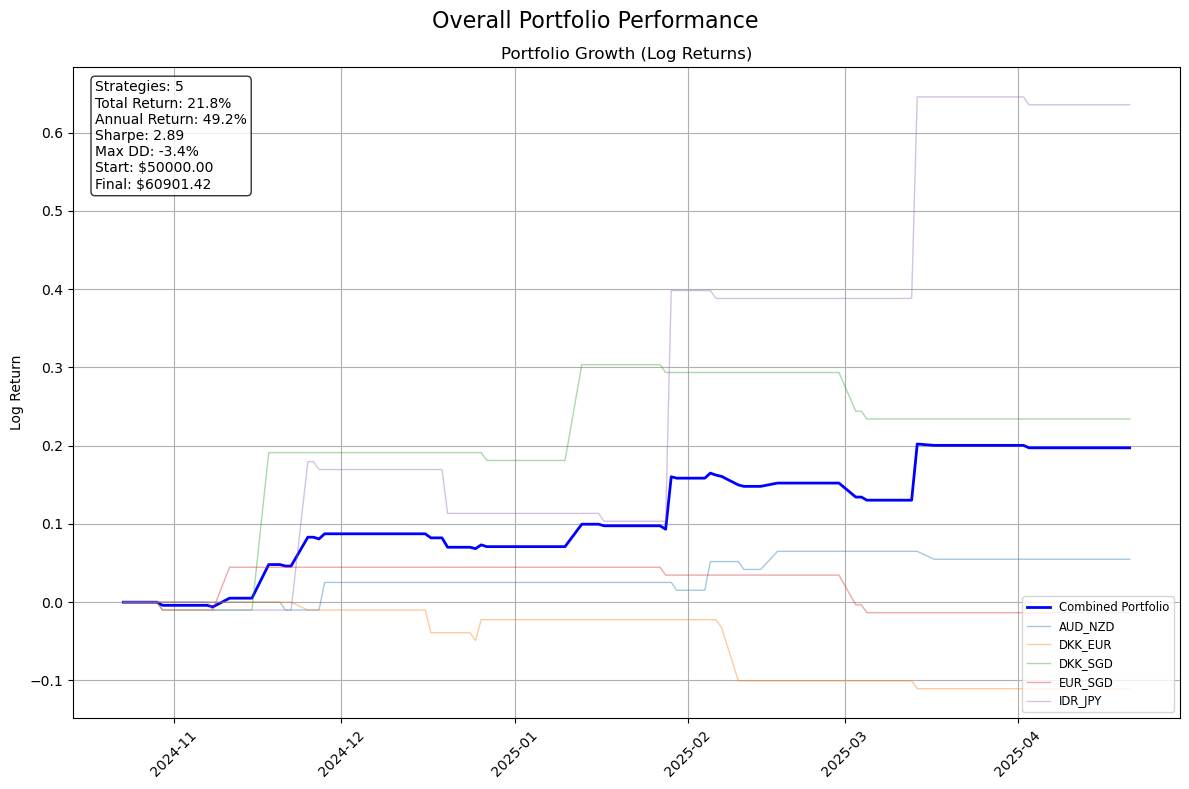

/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_32745/2459912693.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


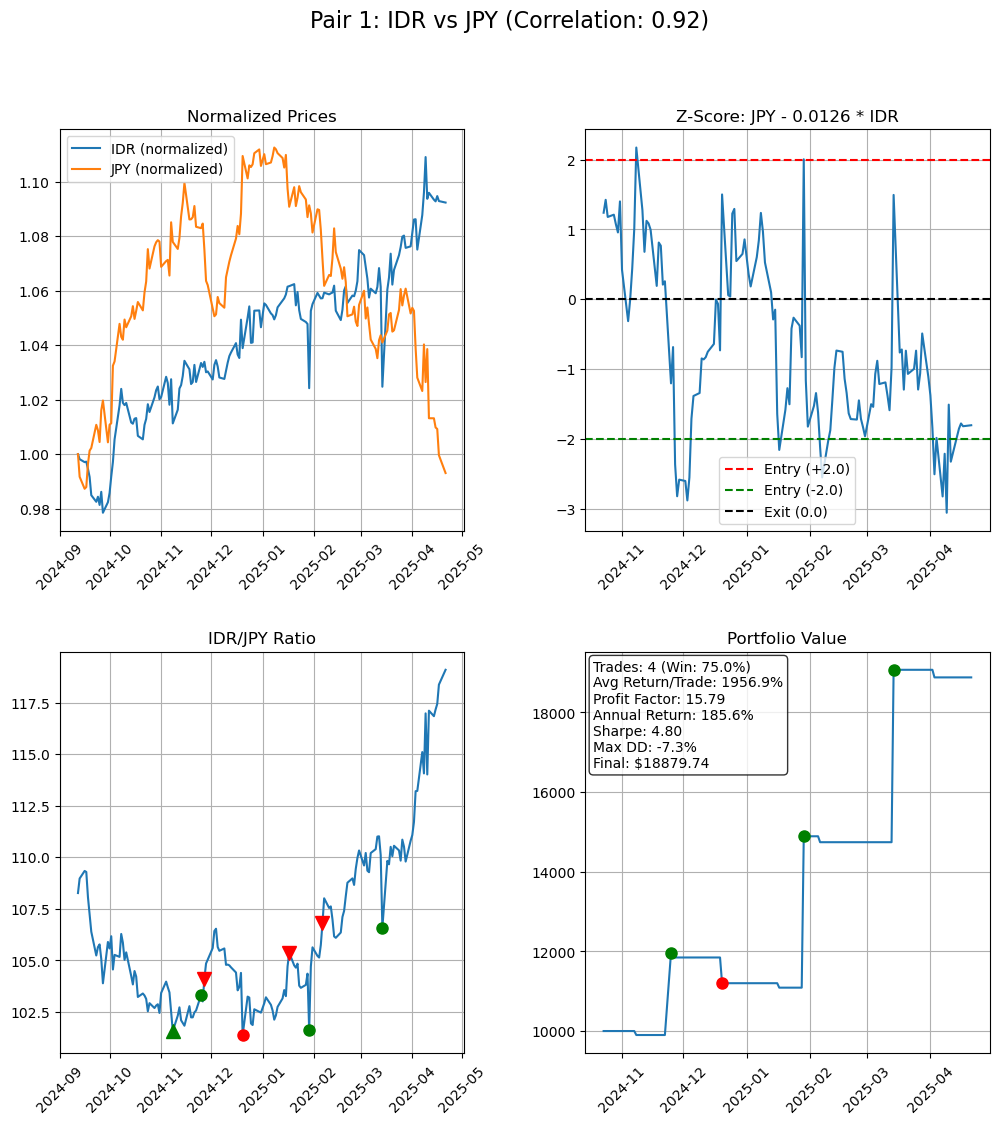

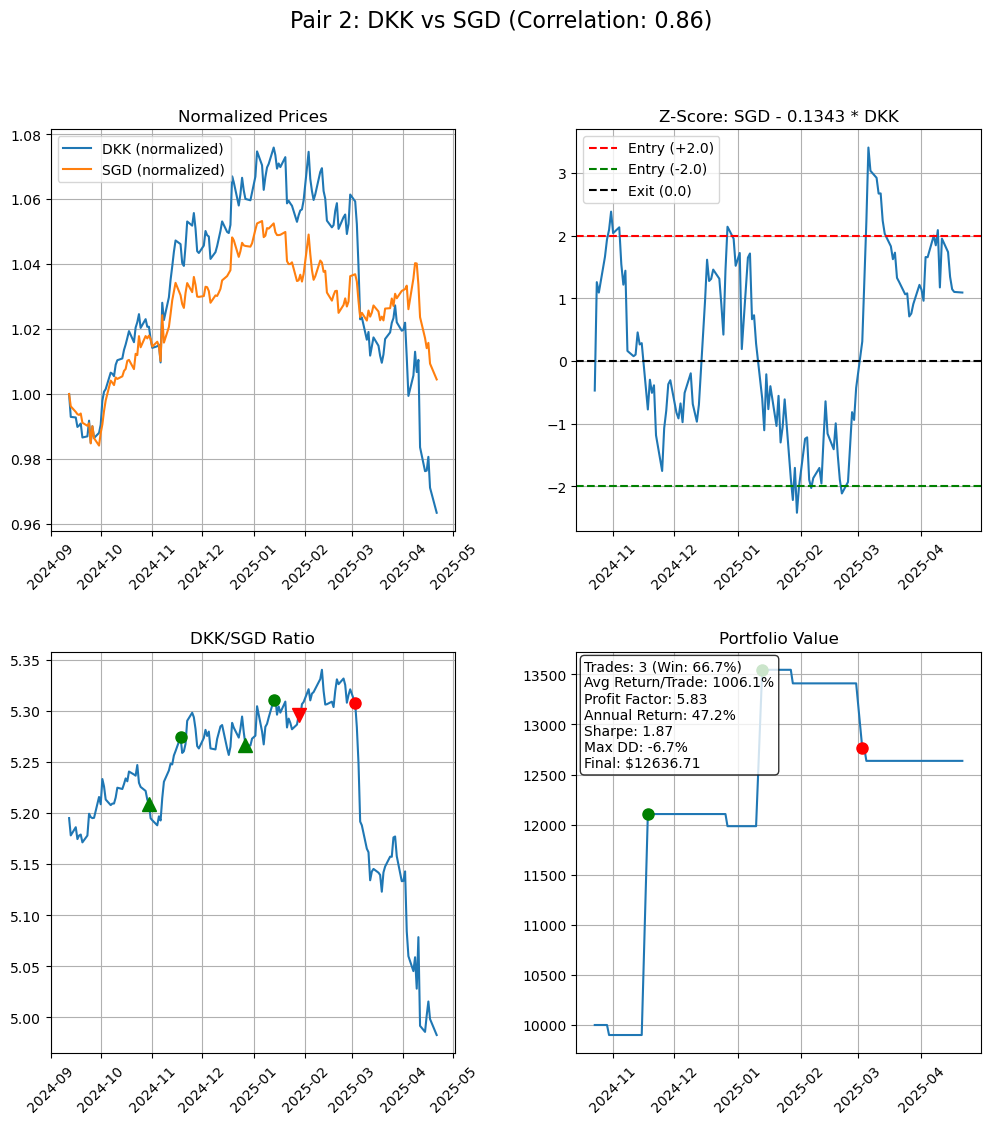

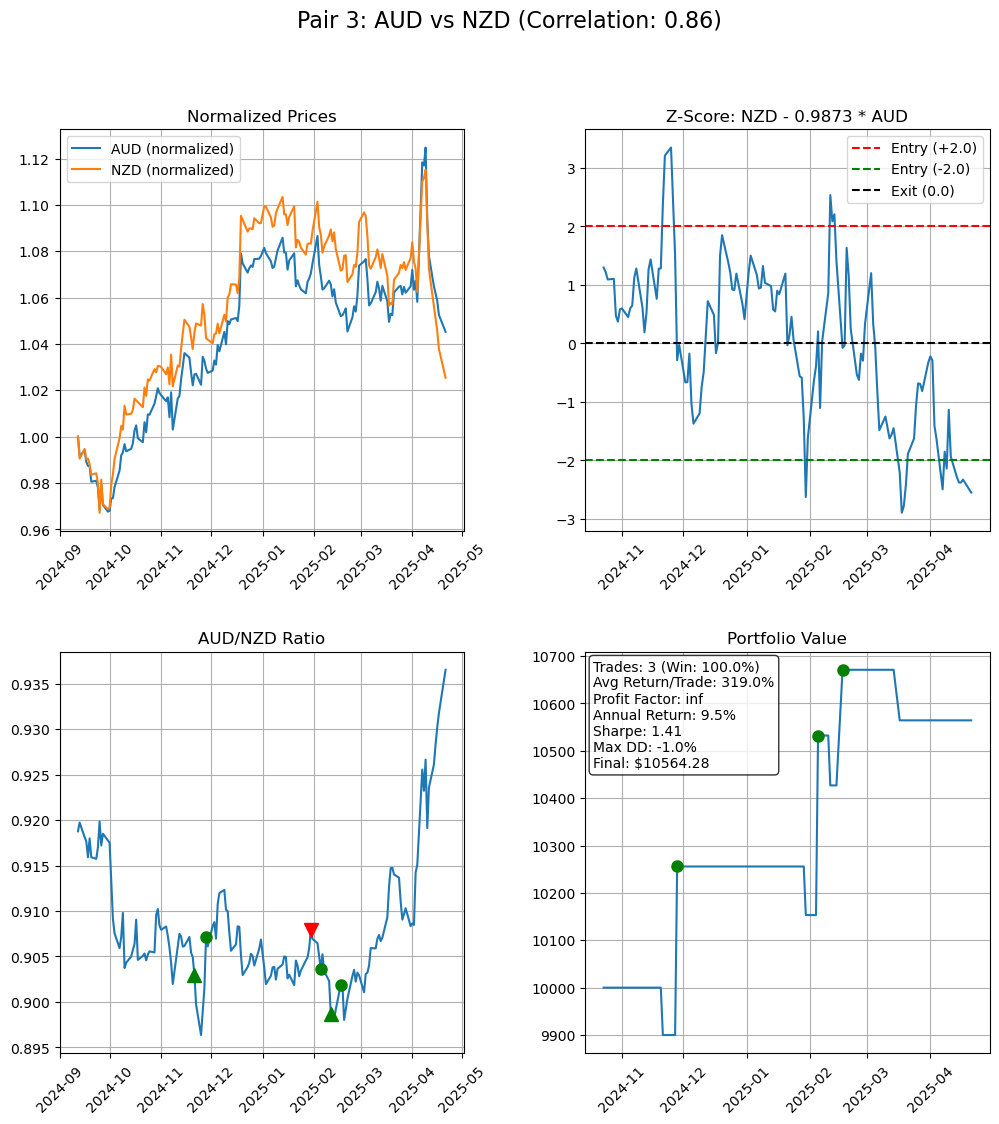

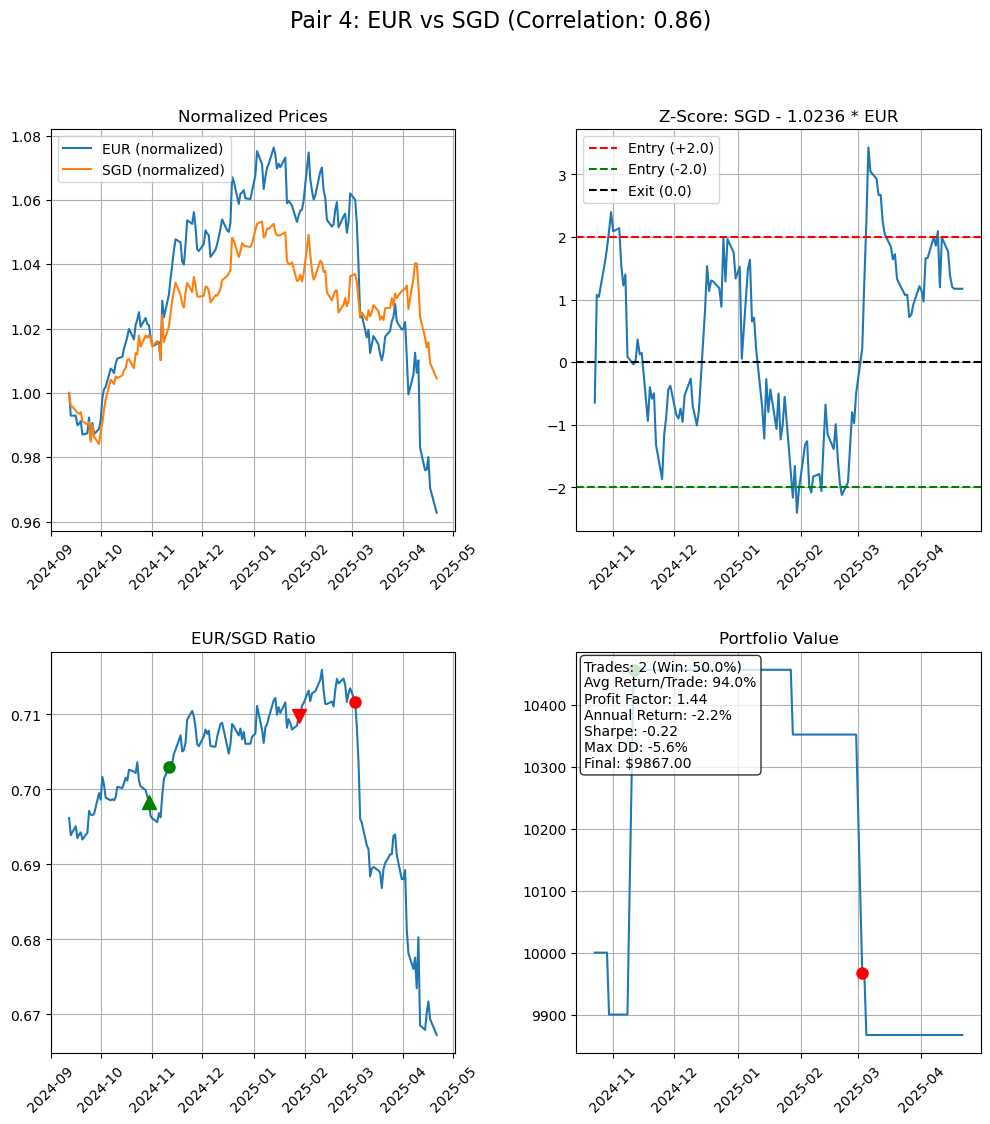

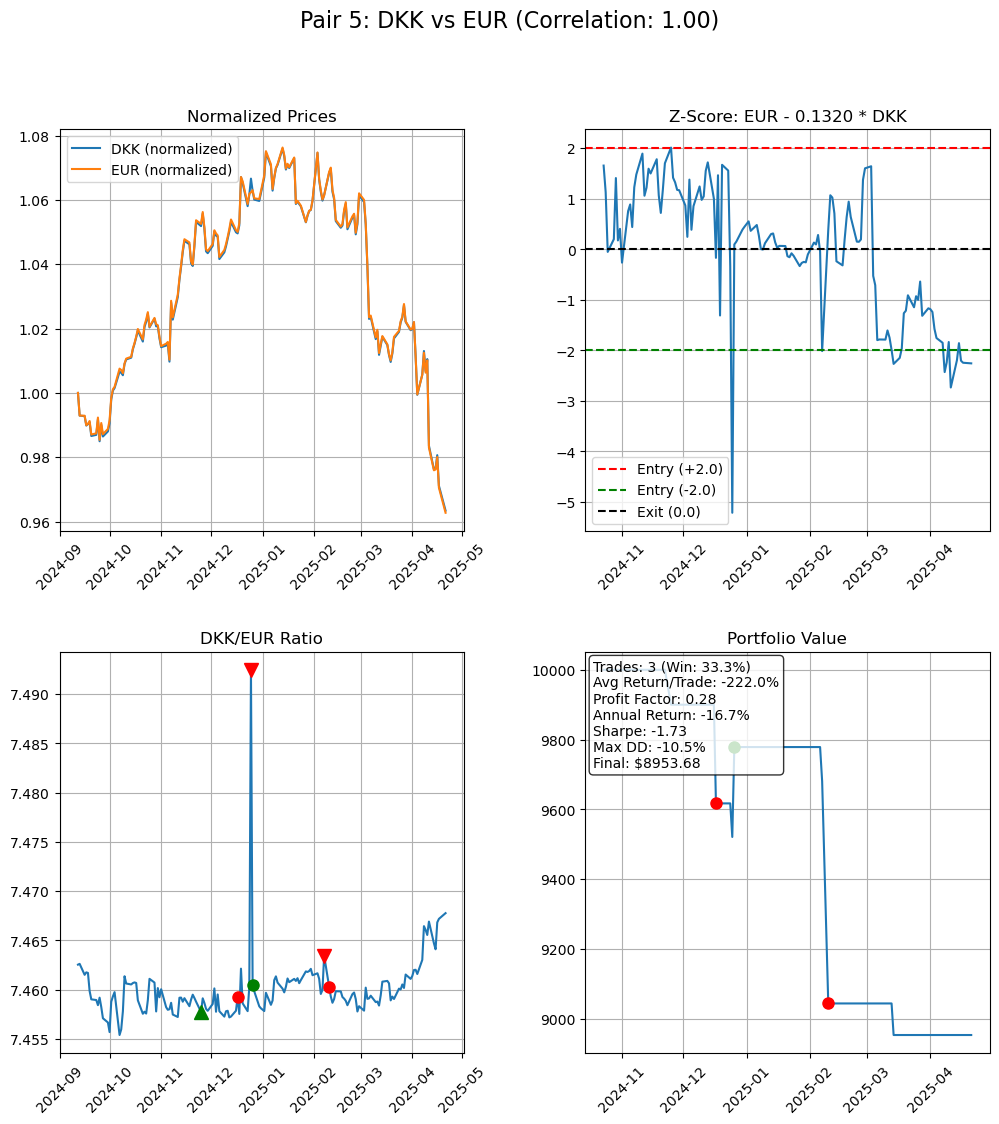

In [95]:
if not backtest_results.empty:
    # Display backtest summary table first
    print("Backtest Results Summary:")
    summary_cols = ['pair1', 'pair2', 'correlation', 'total_trades', 'win_rate', 
                    'annual_return', 'sharpe_ratio', 'max_drawdown', 'final_portfolio_value']
    
    # Format the results for better readability
    summary_df = backtest_results[summary_cols].copy()
    summary_df['win_rate'] = summary_df['win_rate'].map('{:.2%}'.format)
    summary_df['annual_return'] = summary_df['annual_return'].map('{:.2f}%'.format)
    summary_df['sharpe_ratio'] = summary_df['sharpe_ratio'].map('{:.2f}'.format)
    summary_df['max_drawdown'] = summary_df['max_drawdown'].map('{:.2f}%'.format)
    summary_df['final_portfolio_value'] = summary_df['final_portfolio_value'].map('${:.2f}'.format)
    
    summary_df = summary_df.sort_values('sharpe_ratio', ascending=False).reset_index(drop=True)
    print(summary_df.head(3))

    plot_backtest_results(backtest_results)
else:
    print("No pairs met the correlation threshold criteria.")